In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
batch_size = 64
image_size = 224

In [5]:
def add_salt_pepper_noise(img):
    noise_percent = np.random.uniform(0.01, 0.25)

    total_pixels = img.shape[0] * img.shape[1]
    noise_pixels = int(total_pixels * noise_percent)
    
    for _ in range(noise_pixels):
        x_rand = np.random.randint(0, img.shape[1])
        y_rand = np.random.randint(0, img.shape[0])

        img[y_rand, x_rand] = 1 if np.random.choice([True, False]) else 0

    return img

In [12]:
#Generate Data Image Augmentation from NFT art collection 2021 https://www.kaggle.com/datasets/vepnar/nft-art-dataset?resource=download-directory 
# The dataset has been split into train and test folders
 
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255) 

datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 15,
    shear_range = 0.25,
    zoom_range = 0.25,
    horizontal_flip = True,
    brightness_range = (0.5, 1.5),
    rescale=1./255,
    preprocessing_function=add_salt_pepper_noise)

seed = 1234

train_anchor_generator = datagen.flow_from_directory(
    '../datasets/train',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='sparse',
    seed=seed)

train_pos_generator = datagen_aug.flow_from_directory(
    '../datasets/train',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='sparse',
    seed=seed)

val_anchor_generator = datagen.flow_from_directory(
    '../datasets/test',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='sparse',
    seed=seed)

val_pos_generator = datagen_aug.flow_from_directory(
    '../datasets/test',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='sparse',
    seed=seed)

Found 21014 images belonging to 21014 classes.
Found 21014 images belonging to 21014 classes.
Found 9006 images belonging to 9006 classes.
Found 9006 images belonging to 9006 classes.


In [13]:
def triplet_pair_generator(anchor_gen, positive_gen):
    while True:
        anchors, y_anc = next(anchor_gen)
        positives, y_pos = next(positive_gen) 
        
        concatenate_img = np.concatenate([anchors, positives], axis=0)
        concatenate_y = np.concatenate([y_anc, y_pos], axis=0)
        
        yield concatenate_img,concatenate_y

In [14]:
train_triplet_generator = triplet_pair_generator(train_anchor_generator, train_pos_generator)
valid_triplet_generator = triplet_pair_generator(val_anchor_generator, val_pos_generator)

In [15]:
def plot_images(generator, row=4):
    x, y = next(generator)
    _batch_size = x.shape[0] 
    plt.figure(figsize=(50, 25))
    
    for i in range(_batch_size // 2):
        plt.subplot(_batch_size//row, _batch_size//row, i+1)       
        plt.imshow(x[i])
        plt.title(y[i])
        plt.axis('off')
        
        offset = (_batch_size // 2)
        plt.subplot(_batch_size//row, _batch_size//row, i+1 + offset)
        plt.imshow(x[i + offset]) 
        plt.title(y[i + offset])
        plt.axis('off')
        
    # plt.tight_layout()
    plt.show()

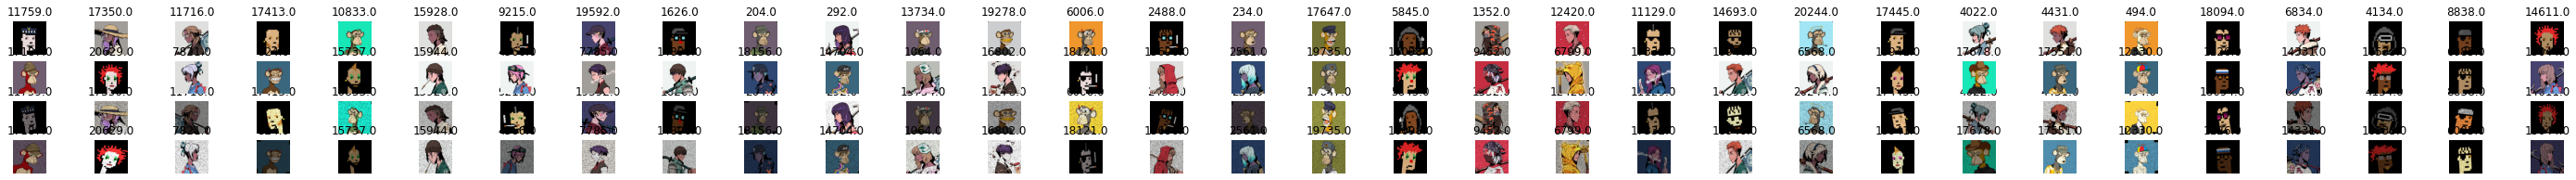

In [16]:
plot_images(train_triplet_generator)

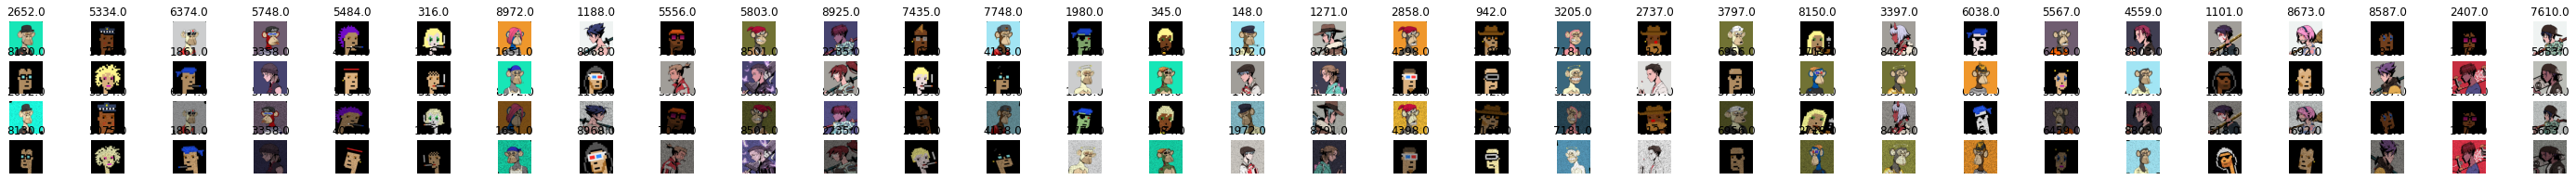

In [17]:
plot_images(valid_triplet_generator)

In [18]:
plagiarism_siamese_Lmodel = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/sayakpaul/convnext_large_21k_224/1",
                   trainable=False), # Freeze feature extractor weights
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation=None), # No activation on the final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
])

plagiarism_siamese_Lmodel.build([None, image_size, image_size, 3])  # Batch input shape.



2023-10-10 04:48:09.080258: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 04:48:09.550793: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21644 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


In [19]:
plagiarism_siamese_Lmodel.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss()
)

In [20]:
plagiarism_siamese_Lmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 21841)             229799953 
                                                                 
 dense (Dense)               (None, 512)               11183104  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 lambda (Lambda)             (None, 128)               0         
                                                                 
Total params: 241,147,281
Trainable params: 11,347,328
Non-trainable params: 229,799,953
_________________________________________________________________


In [21]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    './model/plagiarism_siamese_model_convnext_L_val.h5',
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_freq="epoch",
)

In [22]:
history = plagiarism_siamese_Lmodel.fit(
    train_triplet_generator,
    steps_per_epoch = train_anchor_generator.samples // batch_size,
    validation_data = valid_triplet_generator,
    validation_steps = val_anchor_generator.samples // batch_size,
    epochs = 50,
    callbacks=[model_checkpoint_callback])

Epoch 1/50


2023-10-10 04:53:13.618692: I tensorflow/stream_executor/cuda/cuda_dnn.cc:379] Loaded cuDNN version 8400
2023-10-10 04:53:15.484538: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


328/328 [==============================] - ETA: 0s - loss: 0.7900
Epoch 1: val_loss improved from inf to 0.71777, saving model to ./model/plagiarism_siamese_model_convnext_L_val.h5


ValueError: Unable to create dataset (name already exists)

In [38]:
plagiarism_siamese_Lmodel.save_weights('./model/plagiarism_convnext/plagiarism_siamese_Lmodel_convnext_ver2')

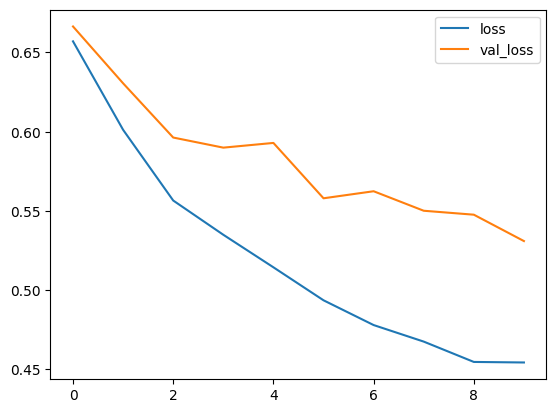

In [39]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [60]:
test_nfts = next(valid_triplet_generator)

In [61]:
test_nft_images, test_nft_labels = test_nfts

In [62]:
test_nft_images.shape

(128, 224, 224, 3)

In [63]:
offset = 10
sample_nfts = test_nft_images[offset:offset+5]
sample_nfts_augmented = test_nft_images[batch_size+offset:batch_size+offset+5]

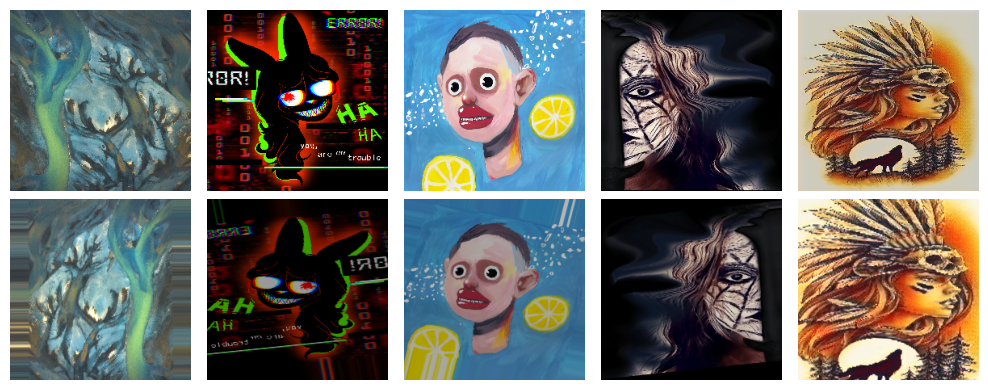

In [64]:
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, i+1)       
    plt.imshow(sample_nfts[i])
    plt.axis('off')
    
    plt.subplot(2, 5, i+6)       
    plt.imshow(sample_nfts_augmented[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [65]:
def plot_images(images, title="Current Database"):
    total_image = len(images)
    fig = plt.figure(figsize=(2*total_image, 3))
    fig.suptitle(title)
    for i in range(total_image):
        plt.subplot(1, total_image, i+1)       
        plt.imshow(images[i])
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

In [66]:
def plot_single_image(image, title):
    fig = plt.figure(figsize=(2, 2))
    plt.imshow(image)
    plt.title(title)
    plt.show()

In [67]:
def compare_image(image1, image2, similarity_threshold=0.65):
    embs = plagiarism_siamese_Lmodel.predict(tf.convert_to_tensor([image1, image2]))
    distance = tf.norm(embs[0] - embs[1])
    
    if distance < similarity_threshold:
        return True, distance
    return False, distance

In [68]:
def simulate_nft_upload(image, simulation_database, similarity_threshold=0.65):
    plot_single_image(image, "Uploading this image")
    
    if len(simulation_database) > 0:
        database_embs = plagiarism_siamese_Lmodel.predict(tf.convert_to_tensor(simulation_database))
        new_img_embs = plagiarism_siamese_Lmodel.predict(tf.expand_dims(image, axis=0))
        
        distances = tf.norm(database_embs - new_img_embs, axis=-1)
        
        nearest_distance_idx = tf.math.argmin(distances)
        nearest_distance = distances[nearest_distance_idx]
        
        if nearest_distance < similarity_threshold:
            plot_images([image, simulation_database[nearest_distance_idx]], "Plagiarism Detected!!! Uploaded image similar to image on database!")
            plot_images(simulation_database, "Current Database (Upload Rejected!)")
            return False, simulation_database
        
    simulation_database.append(image)
    plot_images(simulation_database, "Current Database (Upload Accepted!)")
    return True, simulation_database

In [69]:
simulation_database = []

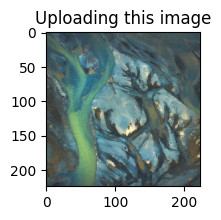

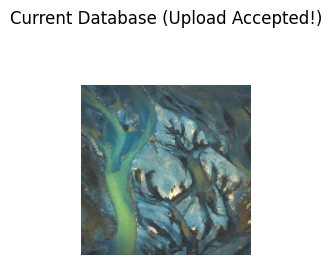

In [70]:
is_approved, simulation_database = simulate_nft_upload(sample_nfts[0], simulation_database)

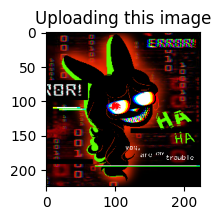

1/1 [==============================] - 0s 34ms/step


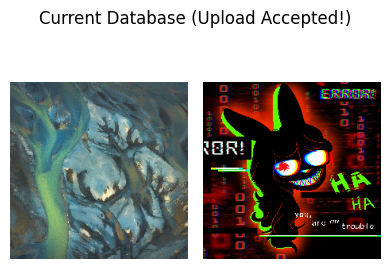

In [71]:
is_approved, simulation_database = simulate_nft_upload(sample_nfts[1], simulation_database)

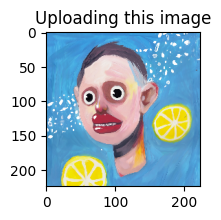

1/1 [==============================] - 0s 34ms/step


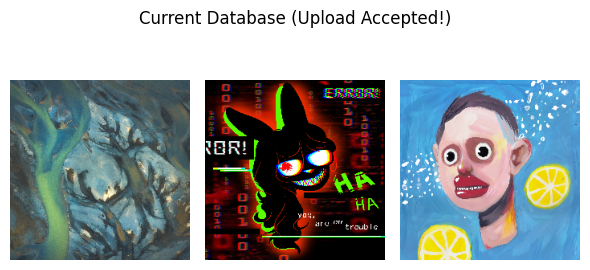

In [72]:
is_approved, simulation_database = simulate_nft_upload(sample_nfts[2], simulation_database)

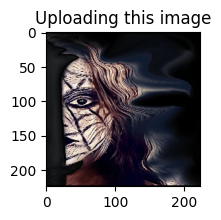

1/1 [==============================] - 0s 34ms/step


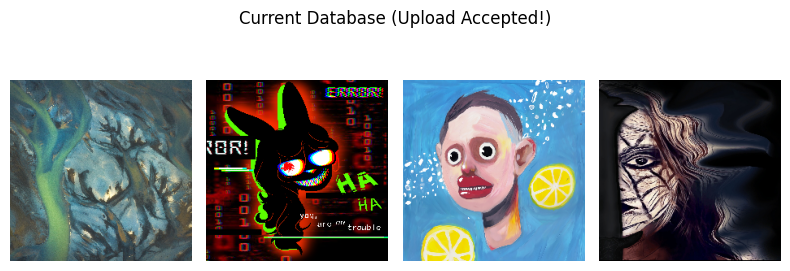

In [73]:
is_approved, simulation_database = simulate_nft_upload(sample_nfts[3], simulation_database)

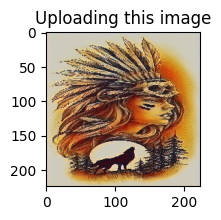

1/1 [==============================] - 0s 32ms/step


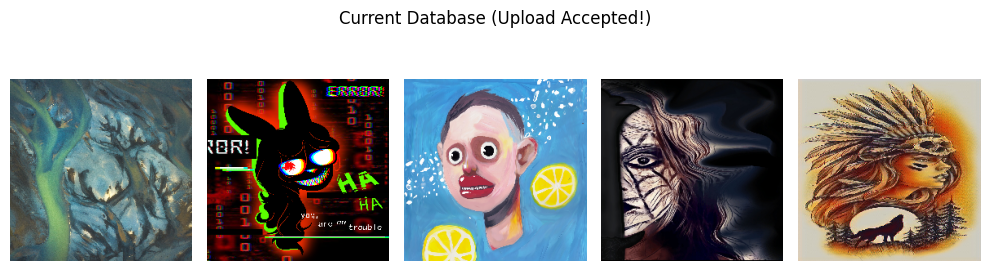

In [74]:
is_approved, simulation_database = simulate_nft_upload(sample_nfts[4], simulation_database)

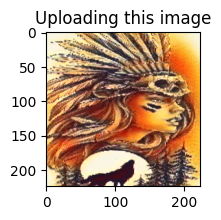

1/1 [==============================] - 0s 33ms/step


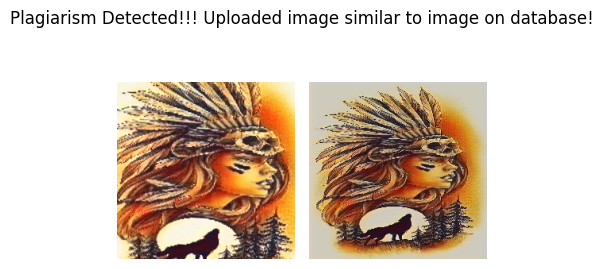

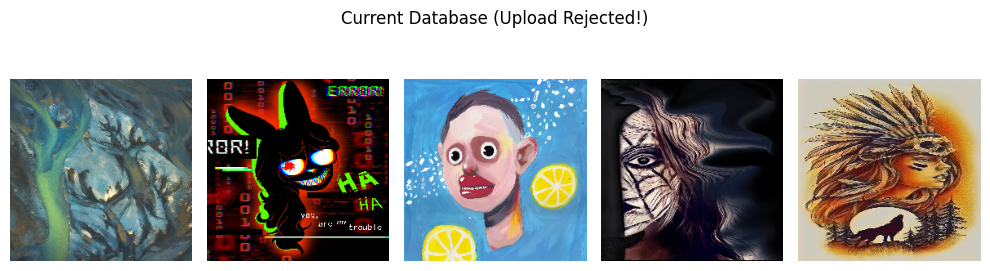

In [75]:
is_approved, simulation_database = simulate_nft_upload(sample_nfts_augmented[4], simulation_database)

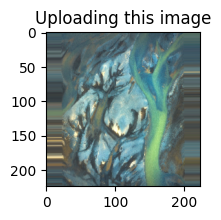

1/1 [==============================] - 0s 35ms/step


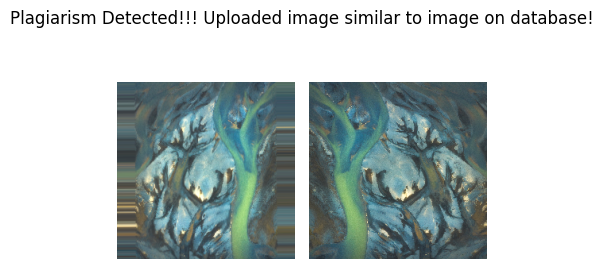

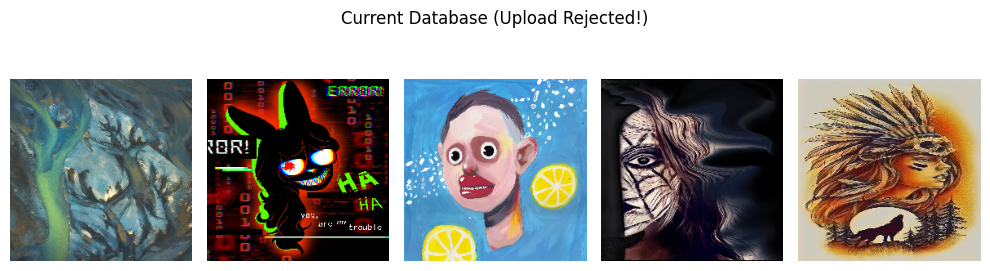

In [76]:
is_approved, simulation_database = simulate_nft_upload(sample_nfts_augmented[0], simulation_database)

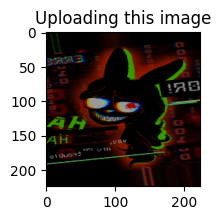

1/1 [==============================] - 0s 33ms/step


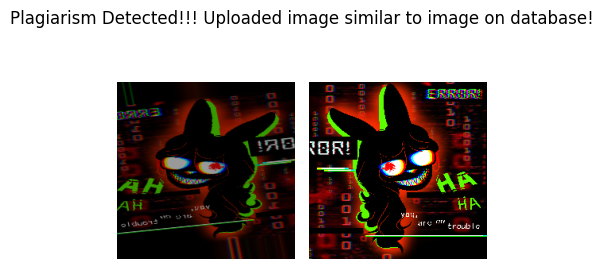

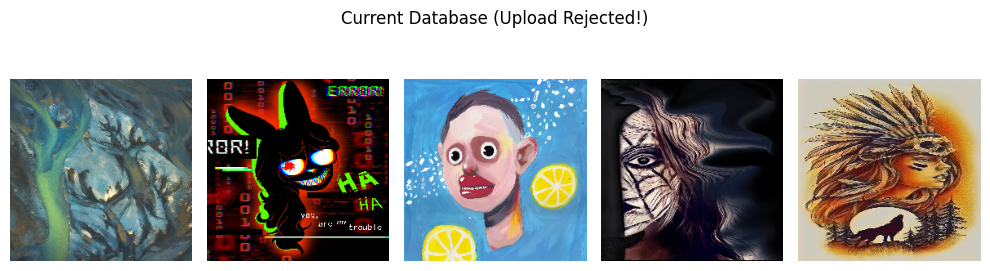

In [77]:
is_approved, simulation_database = simulate_nft_upload(sample_nfts_augmented[1], simulation_database)

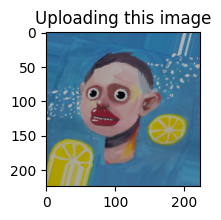

1/1 [==============================] - 0s 32ms/step


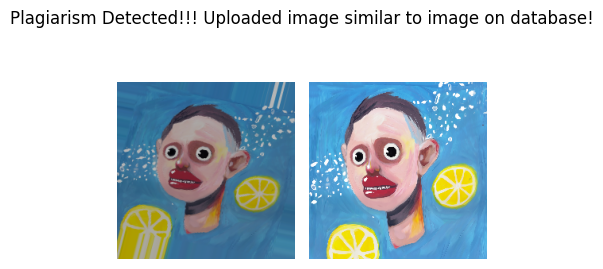

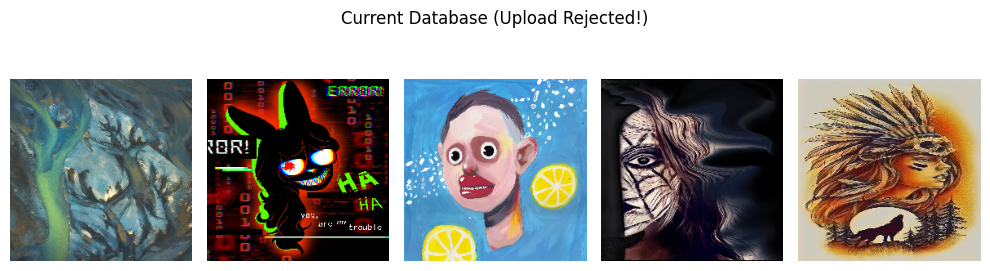

In [78]:
is_approved, simulation_database = simulate_nft_upload(sample_nfts_augmented[2], simulation_database)

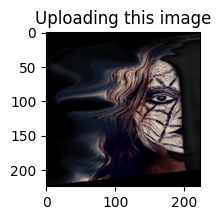

1/1 [==============================] - 0s 34ms/step


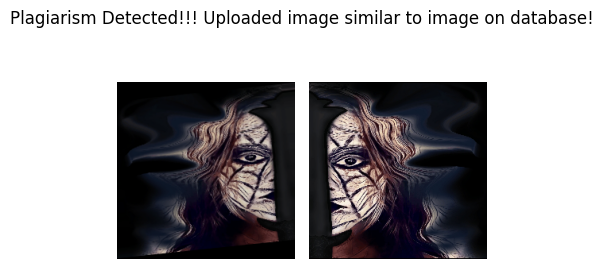

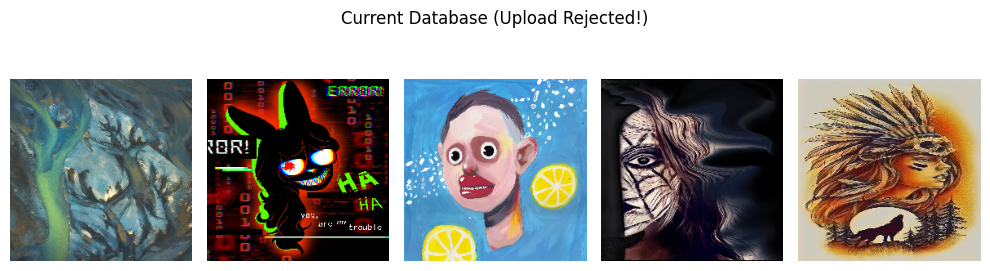

In [79]:
is_approved, simulation_database = simulate_nft_upload(sample_nfts_augmented[3], simulation_database)